In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from math import sqrt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

## Functions

In [4]:
def smape(y_actual, y_pred):
    denominator = np.abs(y_actual) + np.abs(y_pred)
    diff = np.abs(y_actual - y_pred) / denominator
    diff[denominator == 0] = 0  # If both y_actual and y_pred are zero, set to zero
    return np.mean(diff) * 100

## EDA

In [5]:
df = pd.read_csv('merged_table.csv')
print(df.head())

    date      time  ni_in  fe_in  sio2_in  cao_in  mgo_in  al2o3_in  fe_ni  \
0  44197  0.000000   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
1  44197  0.041667   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
2  44197  0.083333   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
3  44197  0.125000   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
4  44197  0.166667   2.09  12.68    37.85    0.42   20.13      1.25   6.06   

    s_m  ...  ni_met  c_met  si_met   fe_met   s_met  ni_slag  fe_slag  \
0  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
1  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
2  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
3  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
4  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   

   t_kalsin  pic_161  loi_kalsin  
0     627.0     -3.0        0.71  
1     607.0     

### Drop and shift some rows

In [6]:
datetime_cols = df.loc[:, 'date':'time'].columns
input_cols = df.loc[:, 'ni_in':'t_tic172'].columns
output_cols = df.loc[:, 'furnace_temp':'loi_kalsin'].columns

# drop rows with on 4/1/2021 to 6/1/2021 and 21/1/2021 to 22/1/2021
df = df[~df['date'].between(44200, 44202)]
df = df[~df['date'].between(44217, 44218)]

shifted_output_df = df[output_cols].shift(18)
df = pd.concat([df[datetime_cols], df[input_cols], shifted_output_df], axis=1)
df = df.drop(index=range(18))

#shift column tco, coltage, current, load, reductor_ratio, charge_kiln 7 rows up
columns_to_shift = ['tco', 'voltage', 'current', 'load', 'reductor_ratio', 'charge_kiln']

# Shift kolom tertentu ke atas 7 baris
shifted_columns = df[columns_to_shift].shift(-7)

# Mengganti kolom asli dengan versi yang telah di-shift
df[columns_to_shift] = shifted_columns

# Menghapus baris terakhir sebanyak 7 baris karena menjadi NaN setelah shift
df = df.iloc[:-7]

df = df.reset_index(drop=True)
print(df.head())

    date      time  ni_in  fe_in  sio2_in  cao_in  mgo_in  al2o3_in  fe_ni  \
0  44197  0.750000    2.0  10.97    36.39    0.36   19.54      1.13    5.5   
1  44197  0.791667    2.0  10.97    36.39    0.36   19.54      1.13    5.5   
2  44197  0.833333    2.0  10.97    36.39    0.36   19.54      1.13    5.5   
3  44197  0.875000    2.0  10.97    36.39    0.36   19.54      1.13    5.5   
4  44197  0.916667    2.0  10.97    36.39    0.36   19.54      1.13    5.5   

    s_m  ...  ni_met  c_met  si_met   fe_met   s_met  ni_slag  fe_slag  \
0  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
1  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
2  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
3  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
4  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   

   t_kalsin  pic_161  loi_kalsin  
0     627.0     -3.0        0.71  
1     607.0     

In [7]:
df.to_csv('shifted_data_18.csv', index=False)

In [8]:
df.isnull().sum()

date                 0
time                 0
ni_in                9
fe_in                9
sio2_in              9
cao_in               9
mgo_in               9
al2o3_in             9
fe_ni                9
s_m                  9
bc                   9
loi_in              33
mc_kilnfeed          8
fc_coal             16
gcv_coal            16
tco                  0
voltage              0
current              0
load                 0
rpm                 88
pry_p               88
sec_p               88
pry_v               88
sec_v               88
total_coal          88
a_f_ratio           88
kg_tco              88
reductor_ratio       0
reductor_consume     0
charge_kiln          0
t_tic162            88
t_tic163            88
t_tic166            88
t_tic172            88
furnace_temp         0
ni_met               0
c_met                0
si_met               0
fe_met               0
s_met                0
ni_slag              0
fe_slag              0
t_kalsin            88
pic_161    

In [9]:
df = df.astype('float64', errors='ignore')
df.dtypes

date                float64
time                float64
ni_in               float64
fe_in               float64
sio2_in             float64
cao_in              float64
mgo_in              float64
al2o3_in            float64
fe_ni               float64
s_m                 float64
bc                  float64
loi_in              float64
mc_kilnfeed         float64
fc_coal             float64
gcv_coal            float64
tco                 float64
voltage             float64
current             float64
load                float64
rpm                 float64
pry_p               float64
sec_p               float64
pry_v               float64
sec_v               float64
total_coal          float64
a_f_ratio           float64
kg_tco              float64
reductor_ratio      float64
reductor_consume    float64
charge_kiln         float64
t_tic162            float64
t_tic163            float64
t_tic166            float64
t_tic172            float64
furnace_temp        float64
ni_met              

In [10]:
df = df.drop(columns=['date', 'time'])
df.columns
df.head()

,ni_in,fe_in,sio2_in,cao_in,mgo_in,al2o3_in,fe_ni,s_m,bc,loi_in,...,ni_met,c_met,si_met,fe_met,s_met,ni_slag,fe_slag,t_kalsin,pic_161,loi_kalsin
0,2.0,10.97,36.39,0.36,19.54,1.13,5.5,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,627.0,-3.0,0.71
1,2.0,10.97,36.39,0.36,19.54,1.13,5.5,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,607.0,-2.7,0.71
2,2.0,10.97,36.39,0.36,19.54,1.13,5.5,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,614.0,-3.1,0.71
3,2.0,10.97,36.39,0.36,19.54,1.13,5.5,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,620.0,-0.9,0.90
4,2.0,10.97,36.39,0.36,19.54,1.13,5.5,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,610.0,-3.0,0.90


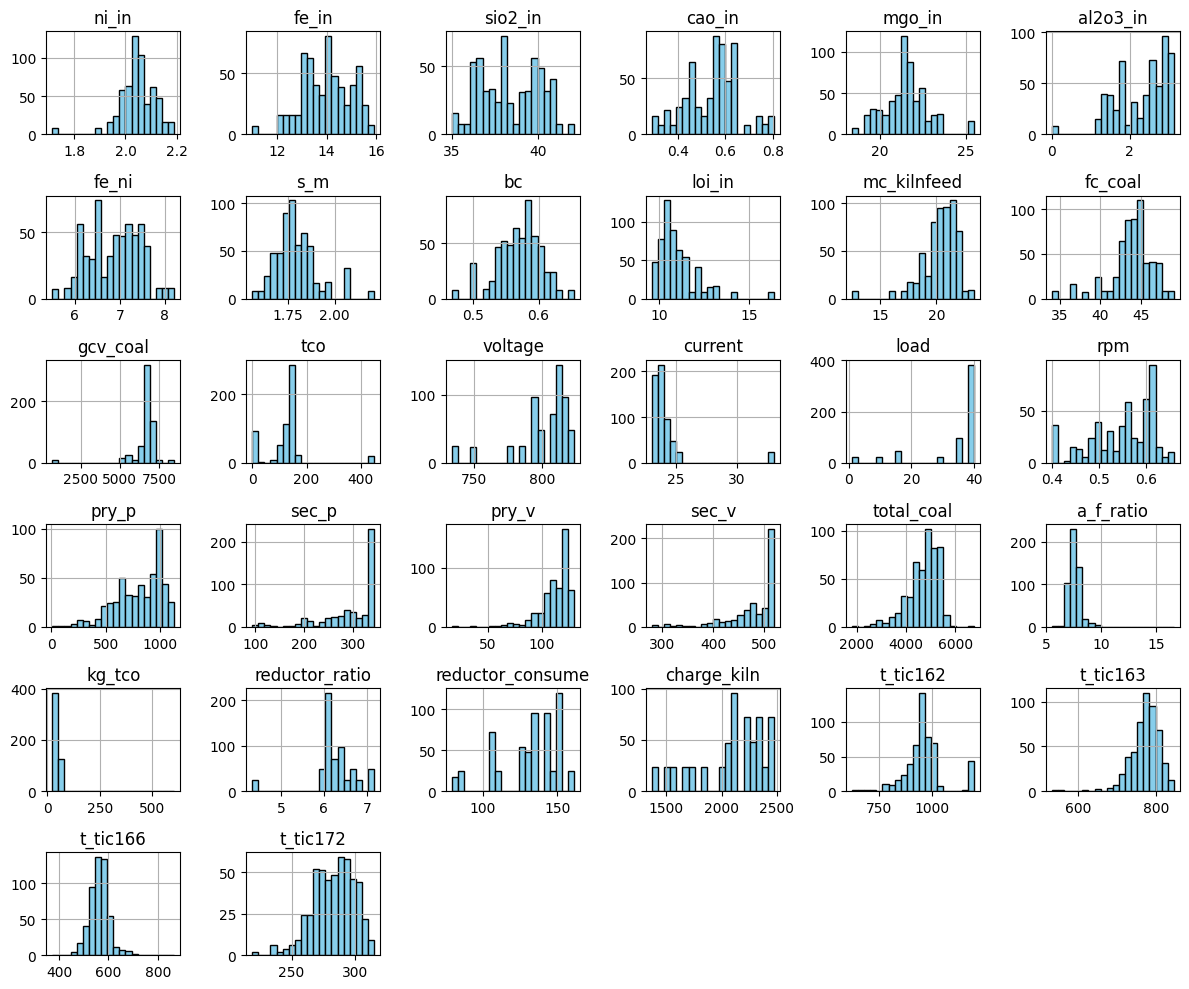

In [11]:
df_input_only = df.drop(columns=output_cols)

# Plot histograms for input columns
df_input_only.hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')

# Show the plots
plt.tight_layout()
plt.show()

### Interpolation

In [12]:
df[input_cols.union(output_cols)] = df[input_cols.union(output_cols)].interpolate(method='linear', axis=0)
print(df[input_cols.union(output_cols)].isnull().sum())

a_f_ratio           0
al2o3_in            0
bc                  0
c_met               0
cao_in              0
charge_kiln         0
current             0
fc_coal             0
fe_in               0
fe_met              0
fe_ni               0
fe_slag             0
furnace_temp        0
gcv_coal            0
kg_tco              0
load                0
loi_in              0
loi_kalsin          0
mc_kilnfeed         0
mgo_in              0
ni_in               0
ni_met              0
ni_slag             0
pic_161             0
pry_p               0
pry_v               0
reductor_consume    0
reductor_ratio      0
rpm                 0
s_m                 0
s_met               0
sec_p               0
sec_v               0
si_met              0
sio2_in             0
t_kalsin            0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
tco                 0
total_coal          0
voltage             0
dtype: int64


In [13]:
df.isnull().sum()

ni_in               0
fe_in               0
sio2_in             0
cao_in              0
mgo_in              0
al2o3_in            0
fe_ni               0
s_m                 0
bc                  0
loi_in              0
mc_kilnfeed         0
fc_coal             0
gcv_coal            0
tco                 0
voltage             0
current             0
load                0
rpm                 0
pry_p               0
sec_p               0
pry_v               0
sec_v               0
total_coal          0
a_f_ratio           0
kg_tco              0
reductor_ratio      0
reductor_consume    0
charge_kiln         0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
furnace_temp        0
ni_met              0
c_met               0
si_met              0
fe_met              0
s_met               0
ni_slag             0
fe_slag             0
t_kalsin            0
pic_161             0
loi_kalsin          0
dtype: int64

In [29]:
df.to_csv('interpolated_data_18.csv', index=False)

### Outlier Removal

In [30]:
# # Calculate the IQR for each column and remove outliers
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# # Filter out rows where any column has a value outside the IQR range
# df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
# df = df.reset_index(drop=True)

# print(f"Cleaned shape (IQR method): {df.shape}")


In [14]:
scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

normalized_df.head()

,ni_in,fe_in,sio2_in,cao_in,mgo_in,al2o3_in,fe_ni,s_m,bc,loi_in,...,ni_met,c_met,si_met,fe_met,s_met,ni_slag,fe_slag,t_kalsin,pic_161,loi_kalsin
0,0.6,0.0,0.19382,0.135922,0.162544,0.359873,0.0,0.462966,0.388446,0.497804,...,0.400031,0.891892,0.671698,0.583395,0.326952,0.909091,0.43017,0.515267,0.356164,0.682692
1,0.6,0.0,0.19382,0.135922,0.162544,0.359873,0.0,0.462966,0.388446,0.497804,...,0.400031,0.891892,0.671698,0.583395,0.326952,0.909091,0.43017,0.438931,0.397260,0.682692
2,0.6,0.0,0.19382,0.135922,0.162544,0.359873,0.0,0.462966,0.388446,0.497804,...,0.400031,0.891892,0.671698,0.583395,0.326952,0.909091,0.43017,0.465649,0.342466,0.682692
3,0.6,0.0,0.19382,0.135922,0.162544,0.359873,0.0,0.462966,0.388446,0.497804,...,0.400031,0.891892,0.671698,0.583395,0.326952,0.909091,0.43017,0.488550,0.643836,0.865385
4,0.6,0.0,0.19382,0.135922,0.162544,0.359873,0.0,0.462966,0.388446,0.497804,...,0.400031,0.891892,0.671698,0.583395,0.326952,0.909091,0.43017,0.450382,0.356164,0.865385


In [15]:
normalized_df.isna().sum()

ni_in               0
fe_in               0
sio2_in             0
cao_in              0
mgo_in              0
al2o3_in            0
fe_ni               0
s_m                 0
bc                  0
loi_in              0
mc_kilnfeed         0
fc_coal             0
gcv_coal            0
tco                 0
voltage             0
current             0
load                0
rpm                 0
pry_p               0
sec_p               0
pry_v               0
sec_v               0
total_coal          0
a_f_ratio           0
kg_tco              0
reductor_ratio      0
reductor_consume    0
charge_kiln         0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
furnace_temp        0
ni_met              0
c_met               0
si_met              0
fe_met              0
s_met               0
ni_slag             0
fe_slag             0
t_kalsin            0
pic_161             0
loi_kalsin          0
dtype: int64

### Correlation Matrix

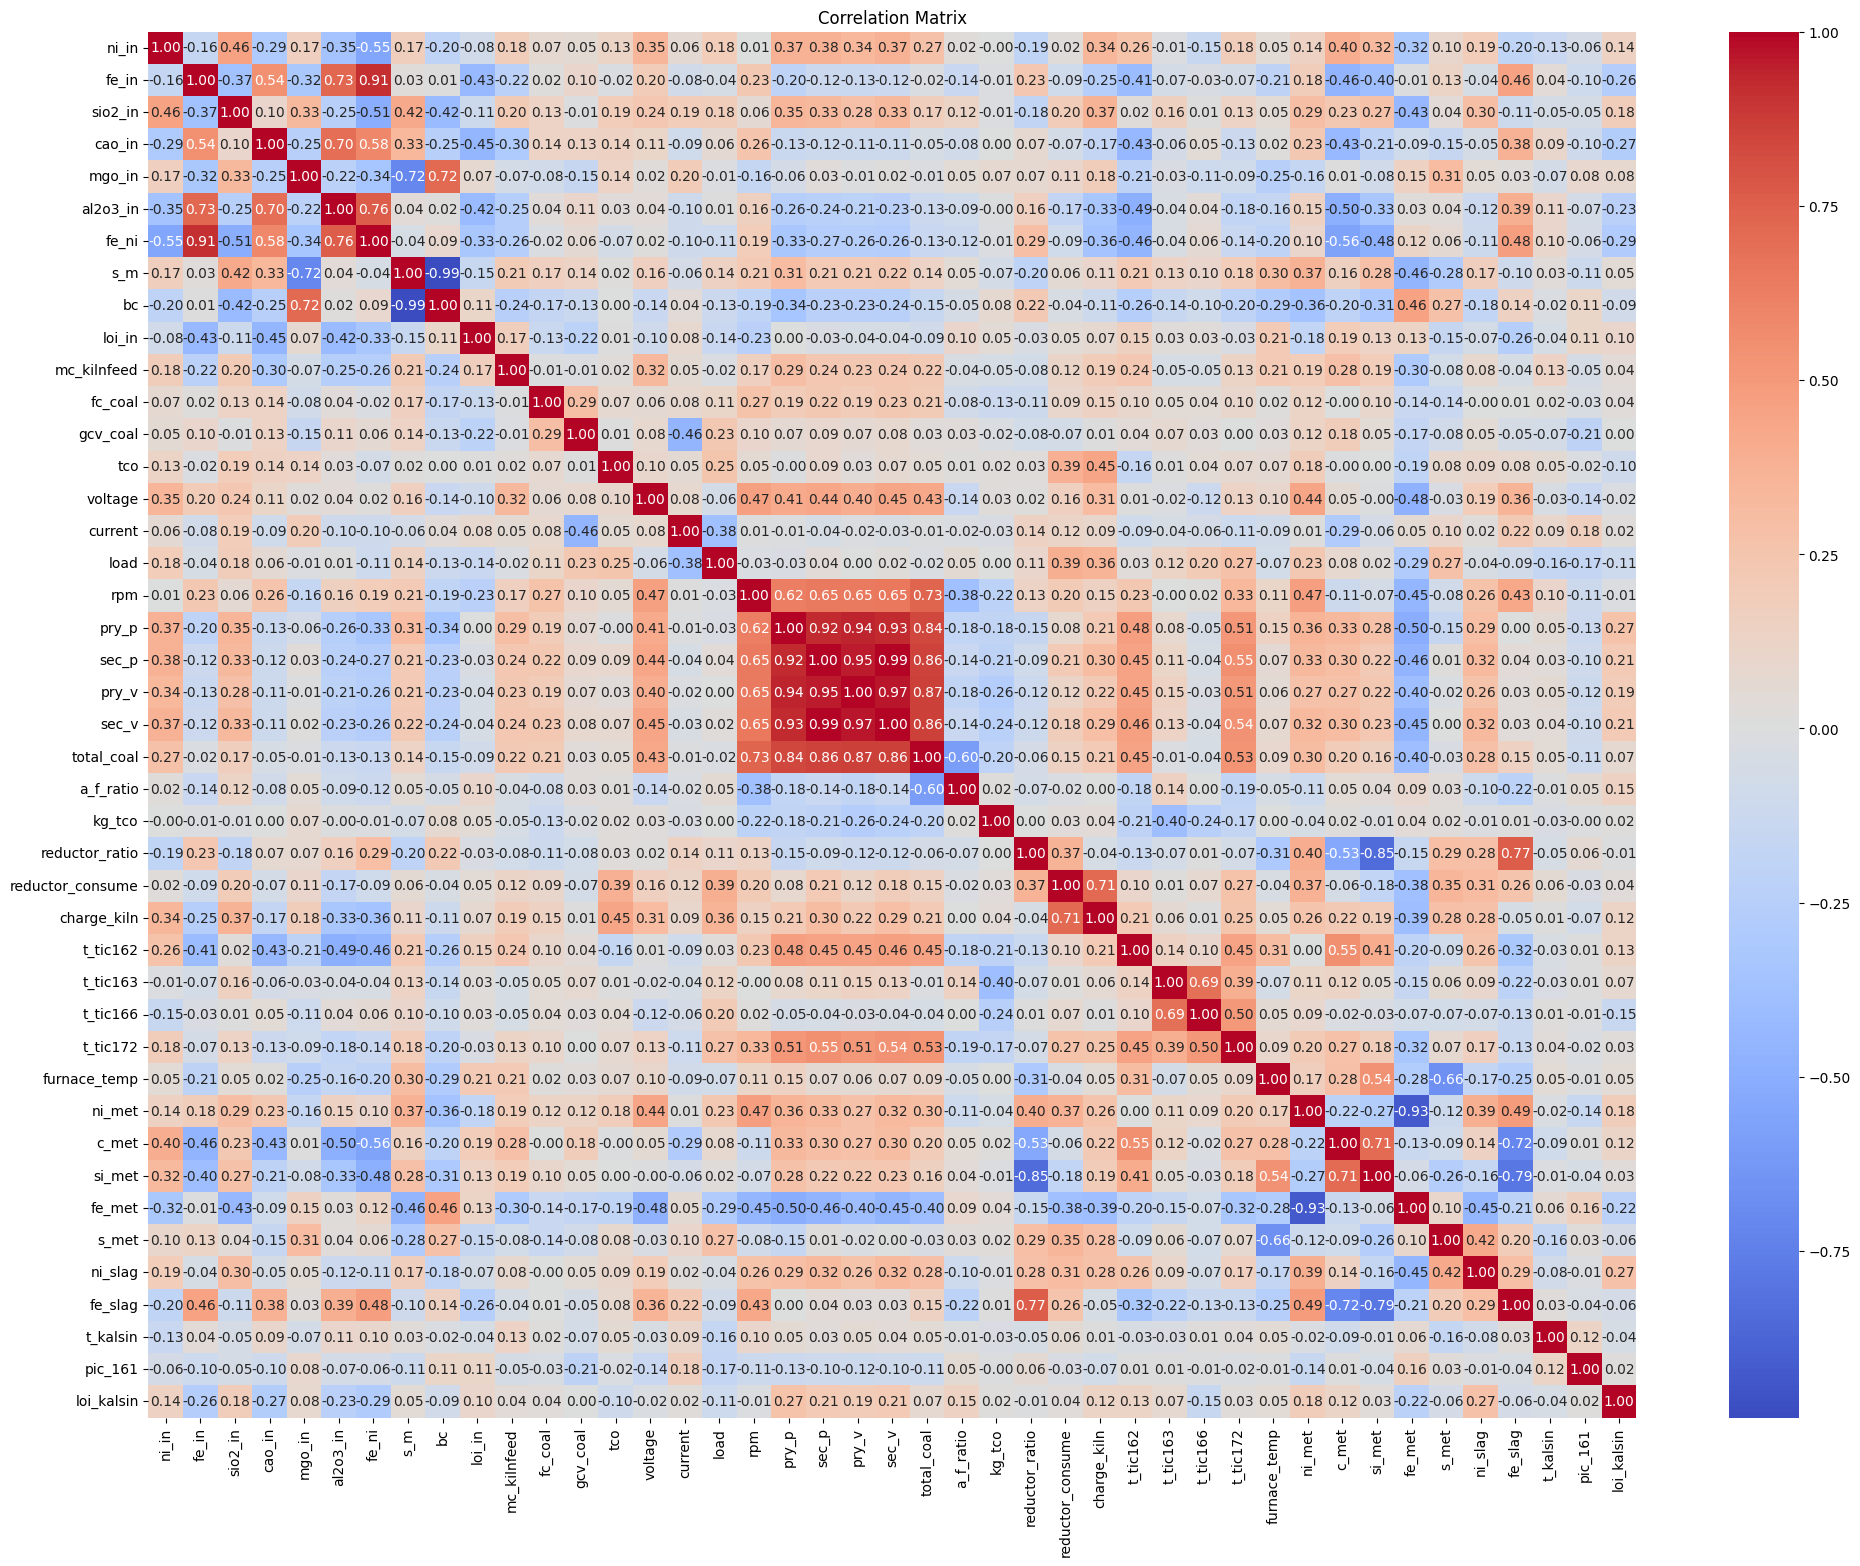

In [16]:
df_corr = normalized_df.corr()
plt.figure(figsize=(24, 18))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix_18.png', dpi=300)
plt.show()

### Data Distributions

<Axes: >

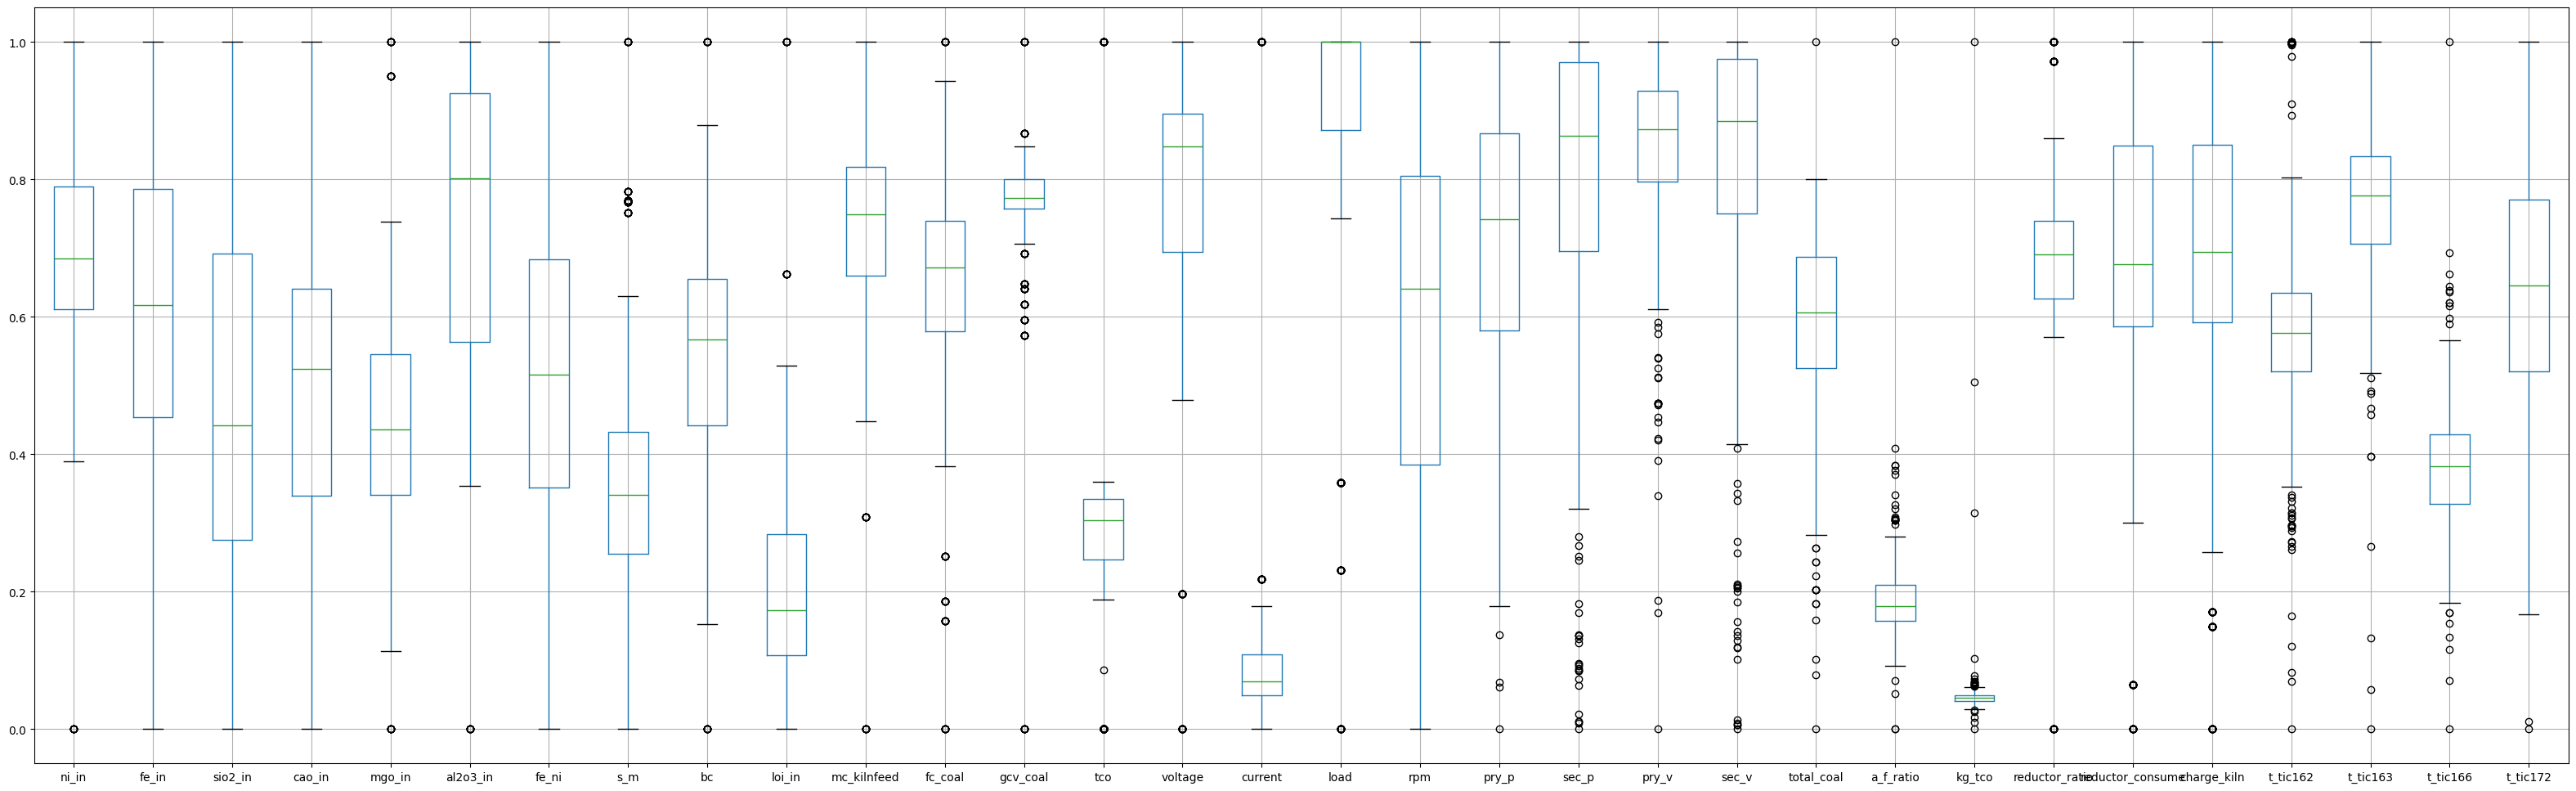

In [17]:
input_data = normalized_df[input_cols]
input_data.boxplot(figsize=(40,12))

### Scatter plots

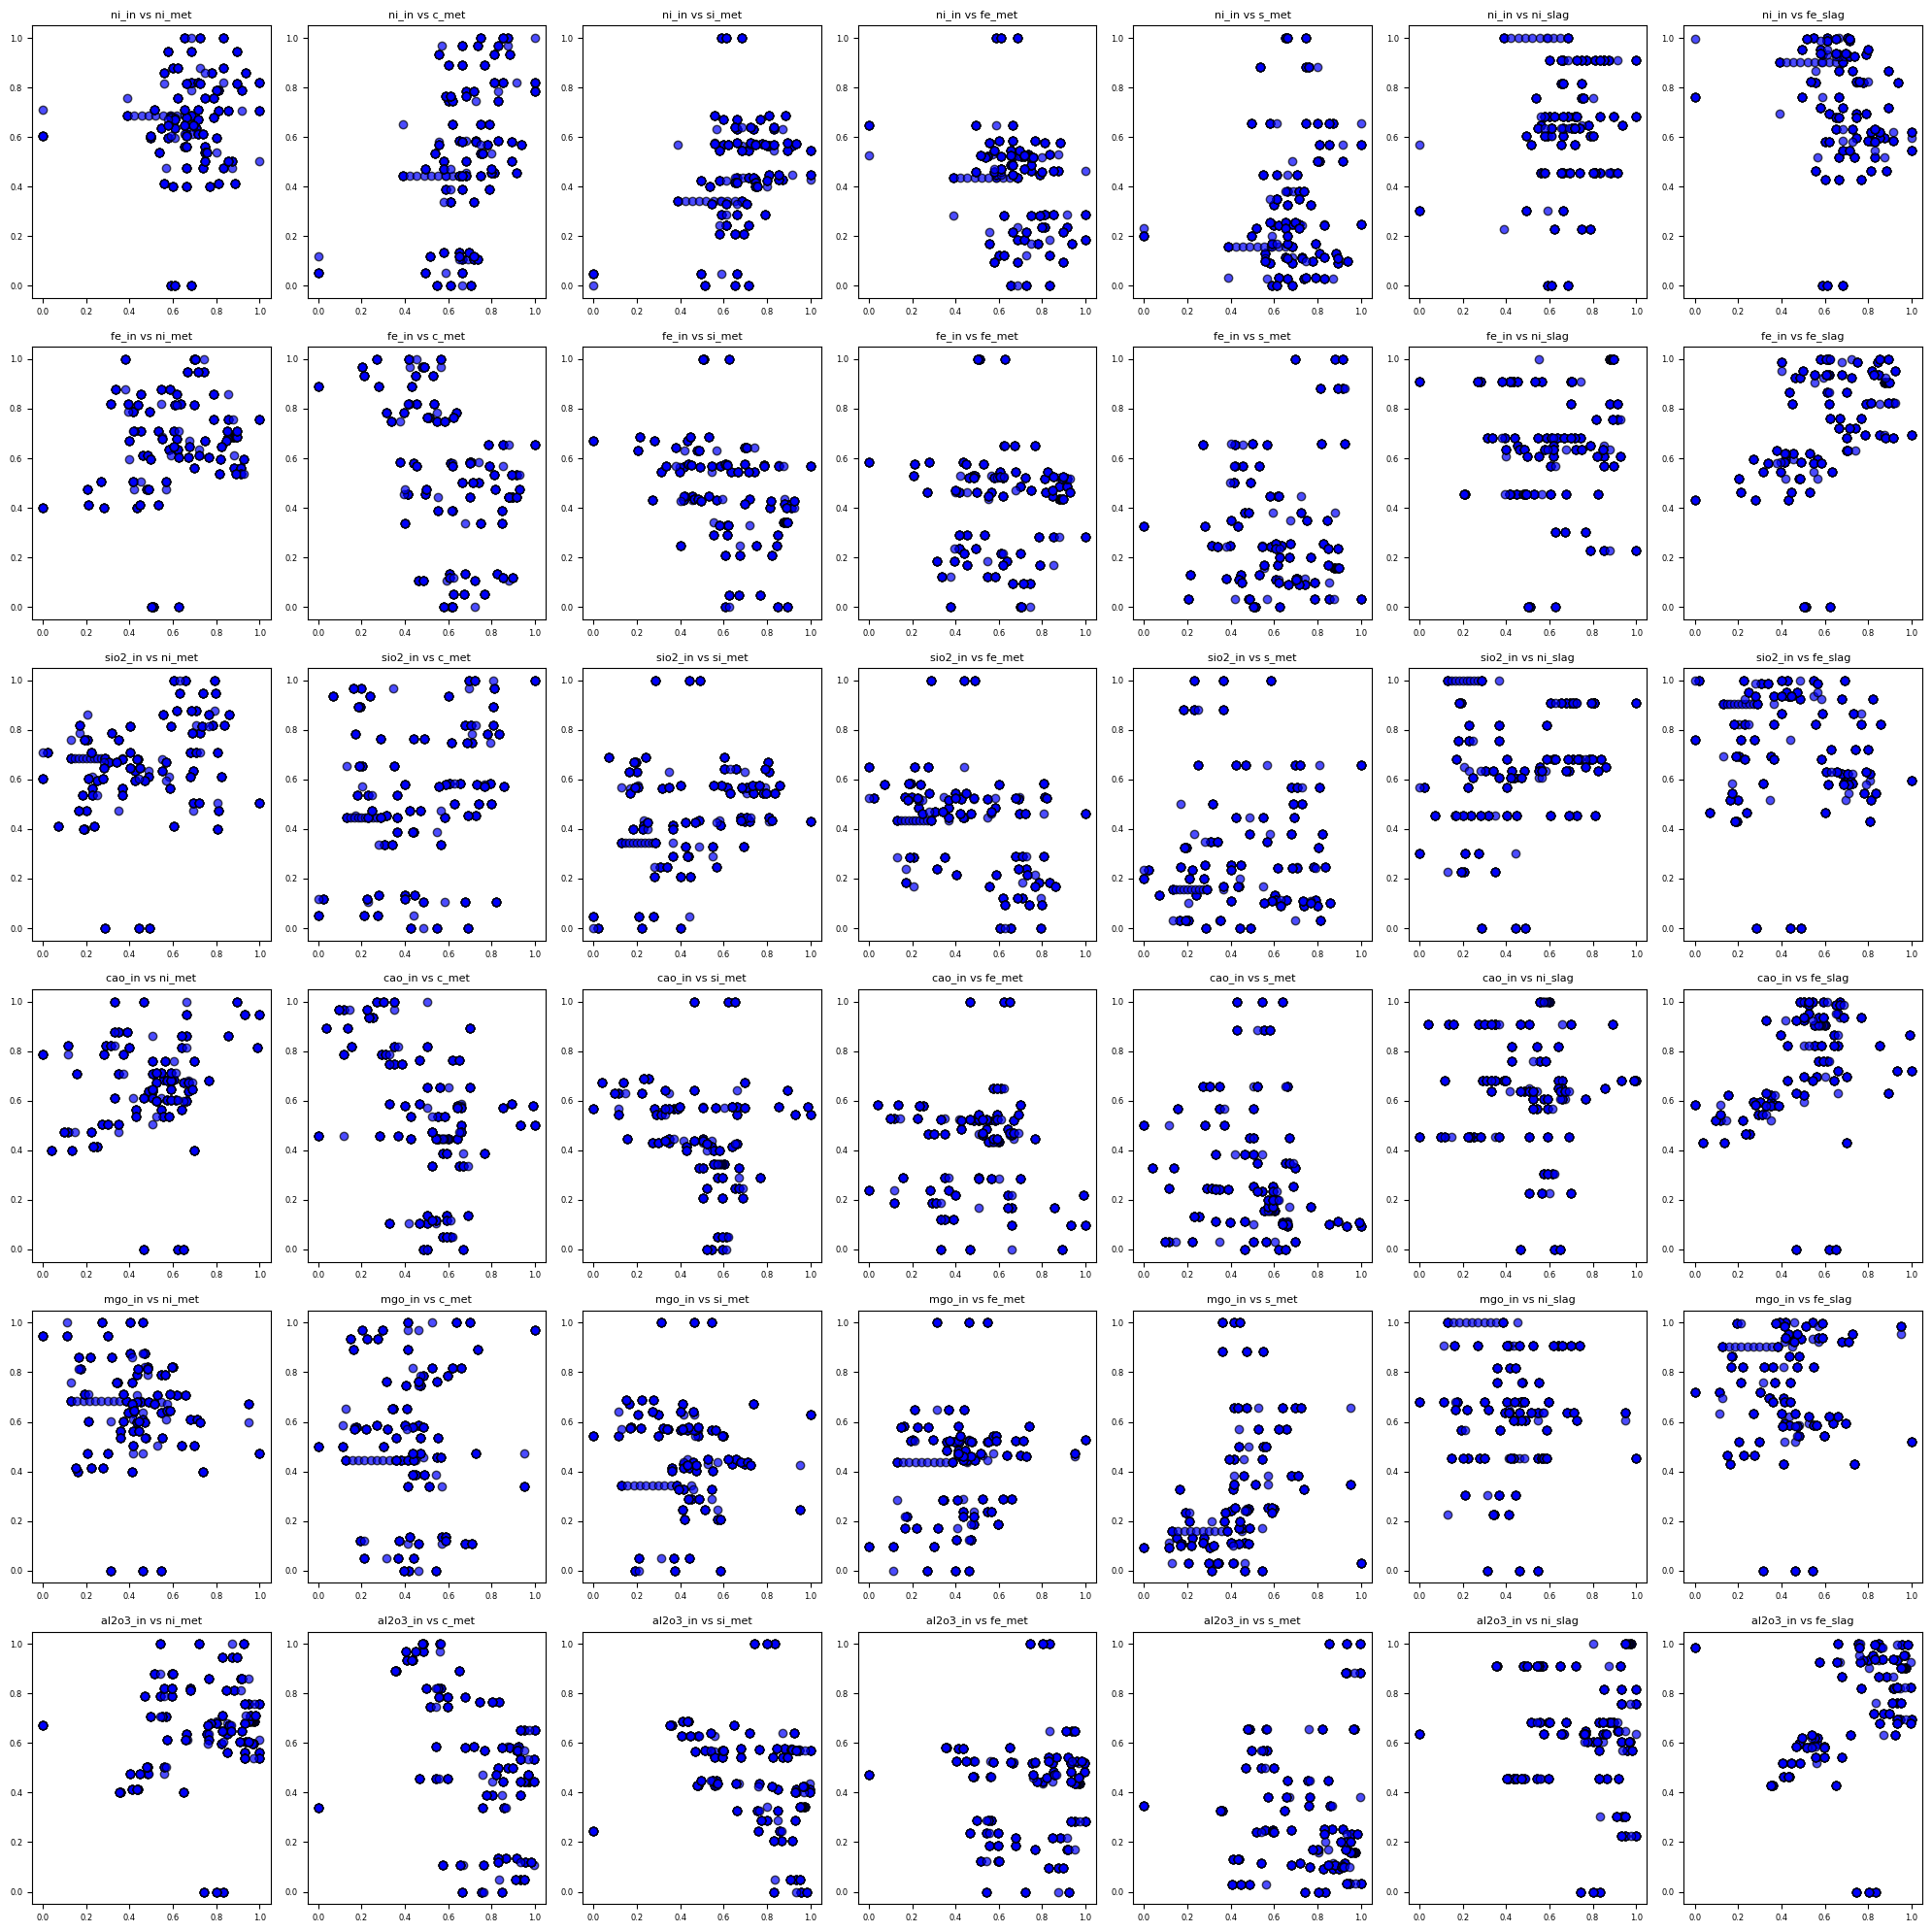

In [18]:
x_columns = normalized_df.loc[:, 'ni_in':'al2o3_in'].columns
y_columns = normalized_df.loc[:, 'ni_met':'fe_slag'].columns

# Setup grid untuk subplots
n_rows = len(x_columns)
n_cols = len(y_columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=False, sharey=False)

# Loop untuk membuat scatter plot setiap pasangan kolom
for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        ax = axes[i, j]
        ax.scatter(normalized_df[x_col], normalized_df[y_col], alpha=0.7, color='blue', edgecolors='black')
        ax.set_title(f'{x_col} vs {y_col}', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.savefig('compositions_plot_18.png', dpi=300)
plt.show()

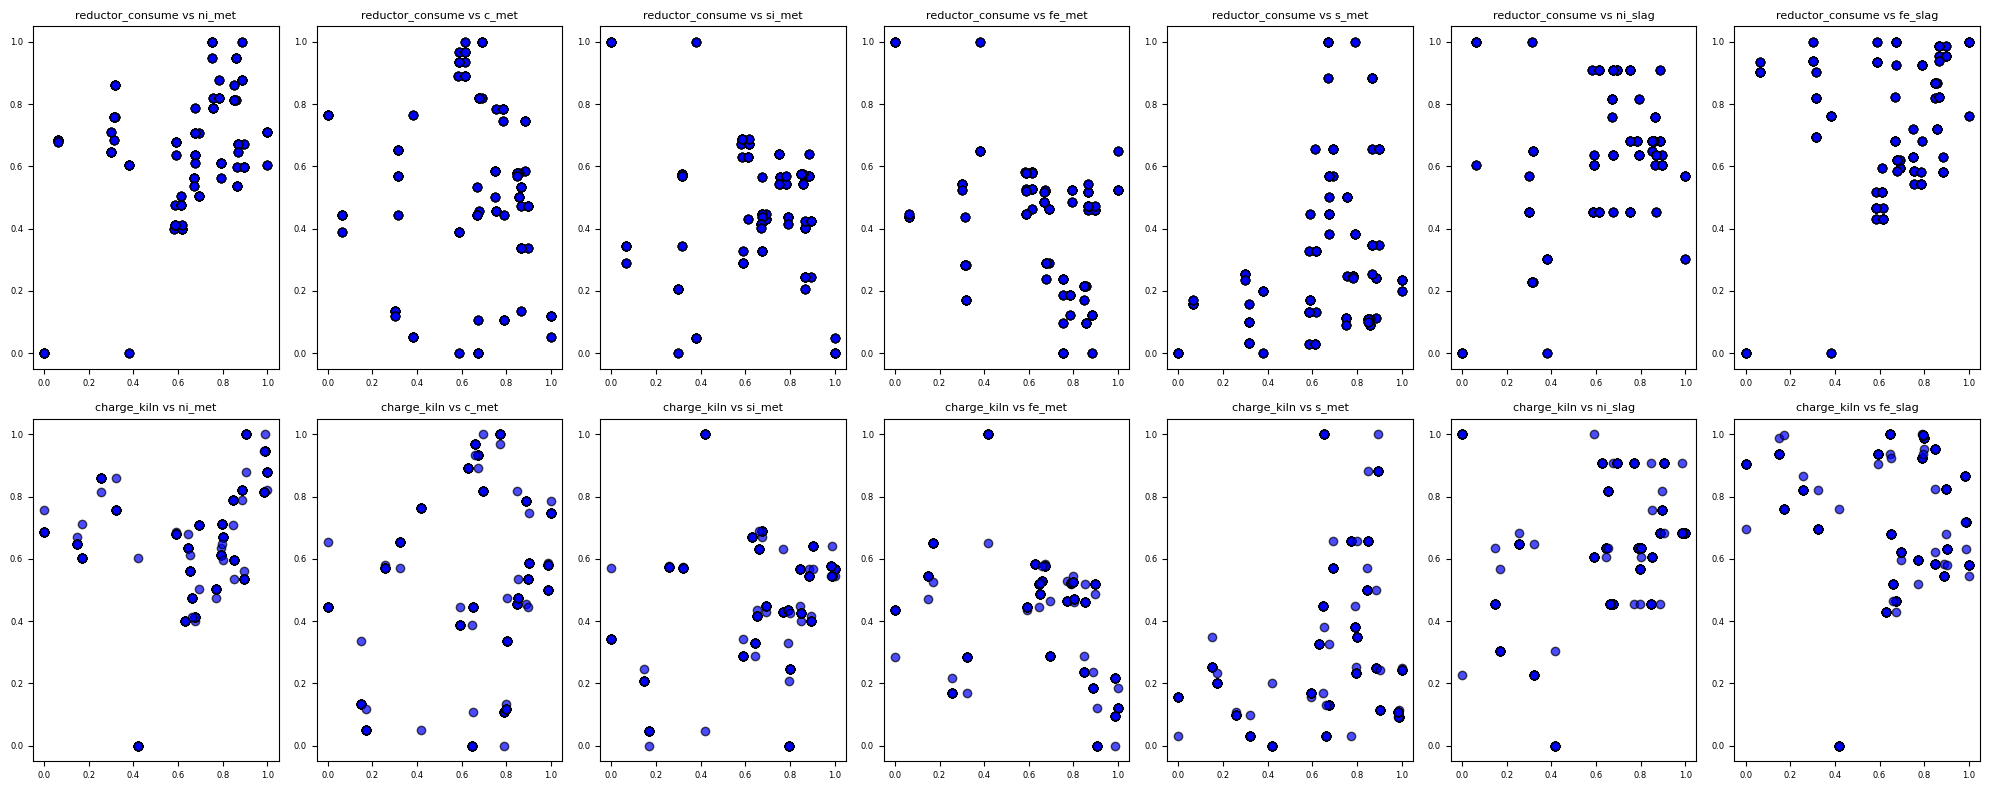

In [19]:
x_columns = normalized_df.loc[:, 'reductor_consume':'charge_kiln'].columns
y_columns = normalized_df.loc[:, 'ni_met':'fe_slag'].columns

# Setup grid untuk subplots
n_rows = len(x_columns)
n_cols = len(y_columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=False, sharey=False)

# Loop untuk membuat scatter plot setiap pasangan kolom
for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        ax = axes[i, j]
        ax.scatter(normalized_df[x_col], normalized_df[y_col], alpha=0.7, color='blue', edgecolors='black')
        ax.set_title(f'{x_col} vs {y_col}', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.savefig('reductors-compositions_plot_18.png', dpi=300)
plt.show()

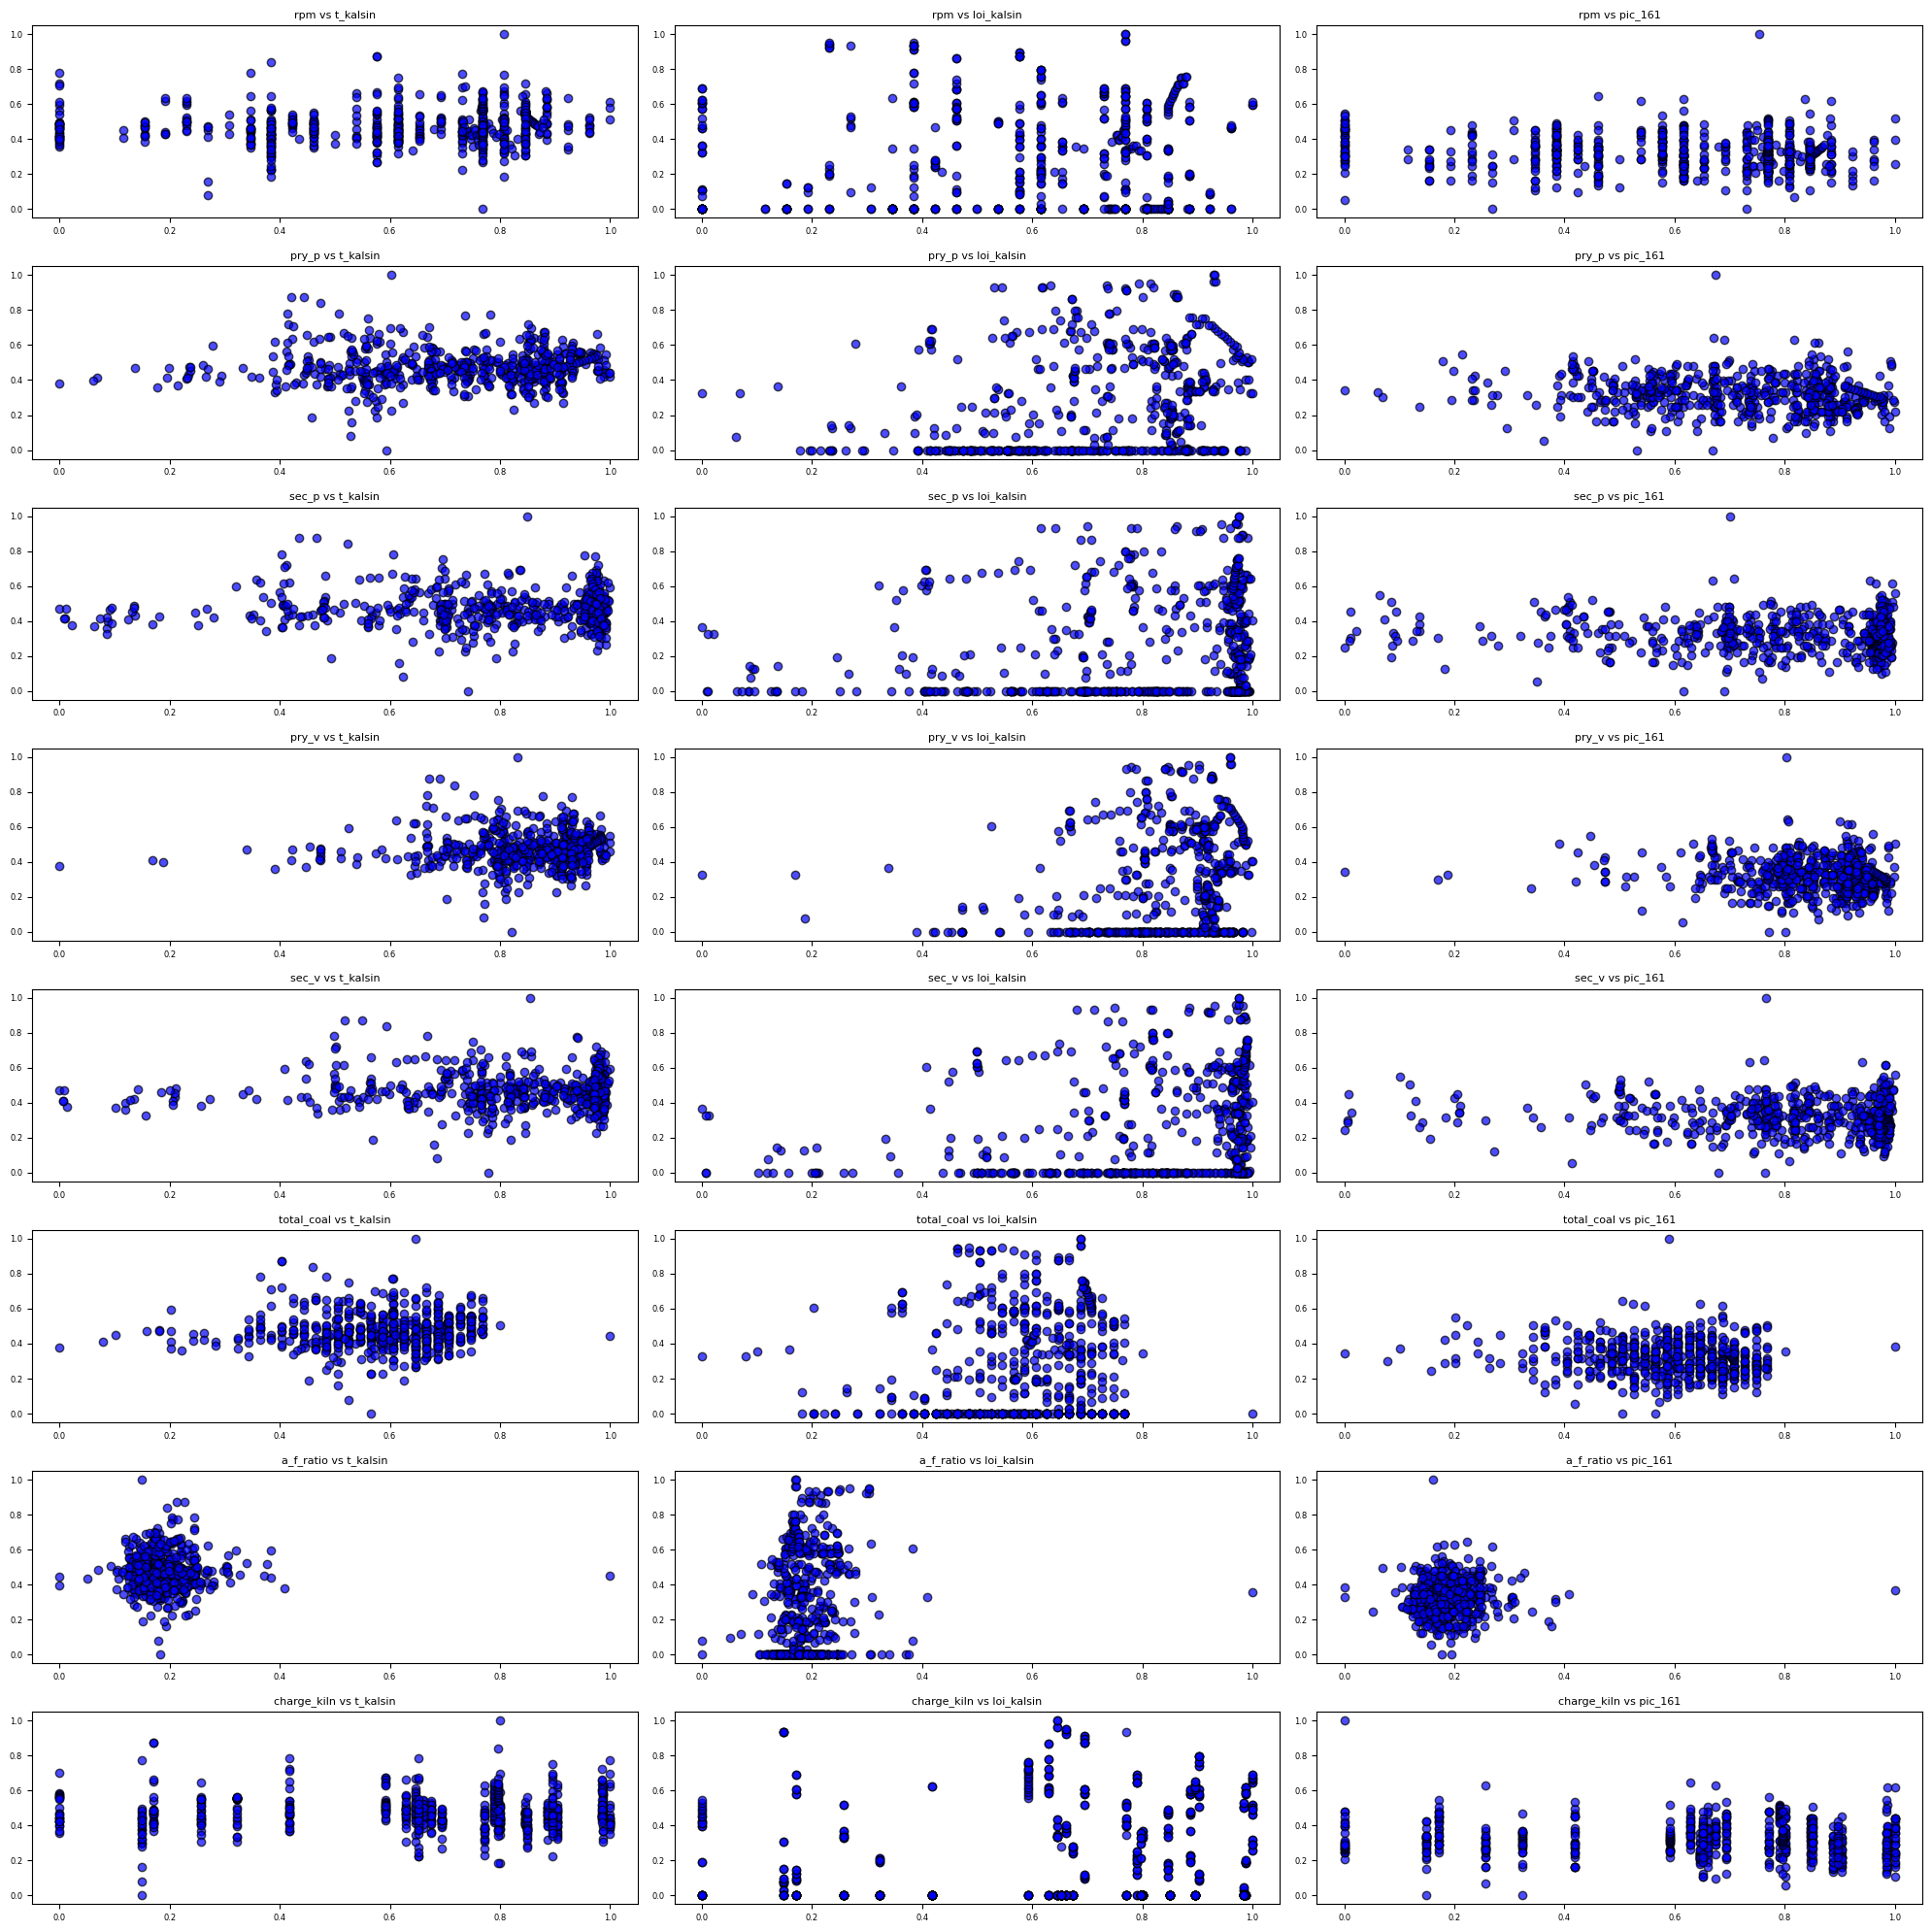

In [20]:
x_columns = ['rpm', 'pry_p', 'sec_p', 'pry_v', 'sec_v', 'total_coal', 'a_f_ratio', 'charge_kiln']
y_columns = ['t_kalsin', 'loi_kalsin', 'pic_161']

# Setup grid untuk subplots
n_rows = len(x_columns)
n_cols = len(y_columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=False, sharey=False)

# Loop untuk membuat scatter plot setiap pasangan kolom
for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        ax = axes[i, j]
        ax.scatter(normalized_df[x_col], normalized_df[y_col], alpha=0.7, color='blue', edgecolors='black')
        ax.set_title(f'{x_col} vs {y_col}', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.savefig('params-kalsin_plot_18.png', dpi=300)
plt.show()

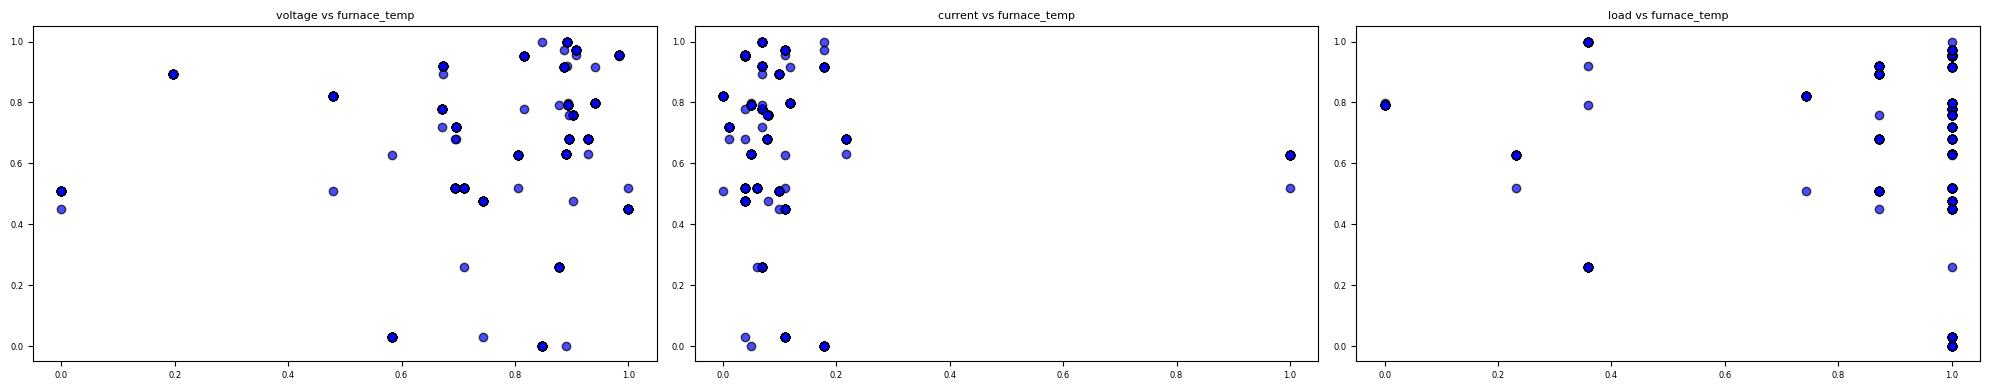

In [21]:
# Define x_columns as a list of columns
x_columns = normalized_df.loc[:, 'voltage':'load'].columns  # Select columns from 'voltage' to 'load'
y_column = ['furnace_temp']  # List of columns for y axis

# Setup grid for subplots
n_cols = len(x_columns)

# Create subplots (1 row, multiple columns)
fig, axes = plt.subplots(1, n_cols, figsize=(20, 4), sharex=False, sharey=False)

# Loop to create scatter plot for each pair of columns
for i, x_col in enumerate(x_columns):
    ax = axes[i]  # Corrected indexing
    ax.scatter(normalized_df[x_col], normalized_df[y_column[0]], alpha=0.7, color='blue', edgecolors='black')
    ax.set_title(f'{x_col} vs {y_column[0]}', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)

# Adjust layout so that plots do not overlap
plt.tight_layout()
plt.savefig('load-furnace_plot_18.png', dpi=300)
plt.show()

## PCA Analysis

In [22]:
pca = PCA()
pca.fit(normalized_df)

# Menentukan jumlah komponen untuk mencapai 95% variansi kumulatif
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.99) + 1

# Melakukan PCA dengan jumlah komponen yang ditemukan
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(normalized_df)

# Membuat dataframe dengan hasil PCA
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Menampilkan hasil PCA
print(f'Number of principal components selected: {n_components}')
print(pca_df.head())

Number of principal components selected: 29
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.382492 -0.956452  0.233736 -0.137498  0.284933  0.259883 -0.504270   
1  0.432137 -1.019755  0.237247 -0.140566  0.271413  0.256812 -0.622121   
2  0.420926 -1.020712  0.234868 -0.143820  0.285555  0.251334 -0.606902   
3  0.457657 -1.031403  0.250044 -0.210415  0.357051  0.331329 -0.662501   
4  0.437932 -1.032430  0.248859 -0.196834  0.373773  0.333942 -0.647220   

        PC8       PC9      PC10  ...      PC20      PC21      PC22      PC23  \
0  0.142906 -0.345381  0.131037  ... -0.001765 -0.024013 -0.057736 -0.006116   
1  0.256324 -0.416210  0.097320  ...  0.076273  0.081638 -0.092986  0.047177   
2  0.257740 -0.397136  0.096834  ...  0.068896  0.081017 -0.107915  0.030288   
3  0.220836 -0.378251  0.183194  ...  0.136423  0.156570  0.033097  0.117289   
4  0.222184 -0.335428  0.169968  ...  0.095153  0.072839 -0.089061 -0.018534   

       PC24      PC25   

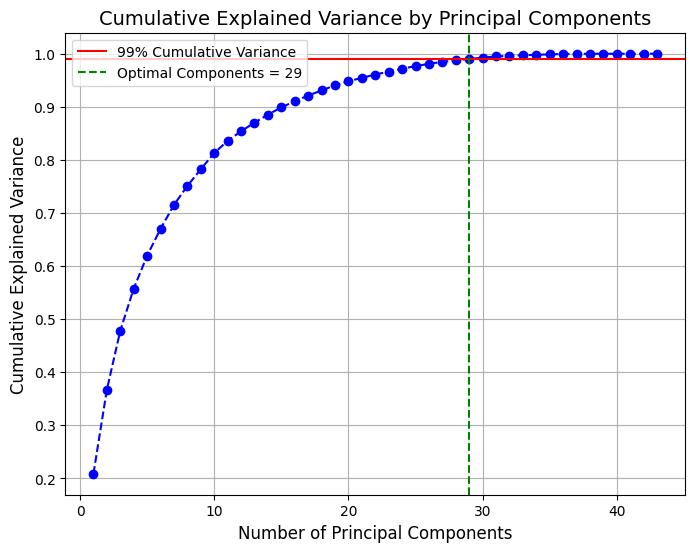

In [23]:
# Plot Cumulative Explained Variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.99, color='r', linestyle='-', label='99% Cumulative Variance')
plt.axvline(x=n_components, color='g', linestyle='--', label=f'Optimal Components = {n_components}')
plt.title('Cumulative Explained Variance by Principal Components', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('variances-pca.png', dpi=300)
plt.show()

## MODELLING

In [24]:
X_merged = pd.concat([normalized_df[input_cols], pca_df], axis=1)
y = normalized_df[output_cols]

# Split into training and testing datasets
X_train_merged, X_test_merged, y_train, y_test = train_test_split(X_merged, y, test_size=0.2, random_state=42)

In [25]:
inverted_actual_df = pd.concat([X_test_merged[input_cols], y_test], axis=1)
inverted_actual_array = scaler.inverse_transform(inverted_actual_df)
inverted_actual_df = pd.DataFrame(inverted_actual_array, columns=inverted_actual_df.columns)


In [26]:
X_train = X_train_merged.drop(columns=normalized_df[input_cols], axis=1)
X_test = X_test_merged.drop(columns=normalized_df[input_cols], axis=1)

## Random Forest

In [27]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## Multi-Layer Perceptron

In [28]:
mlp = MLPRegressor(hidden_layer_sizes=(64, 32),  # Example hidden layers
                   max_iter=500,
                   random_state=42,
                   learning_rate_init=0.02,
                   verbose=True)

# Fit the model
mlp.fit(X_train, y_train)

# Predict on test set
y_pred_mlp = mlp.predict(X_test)

Iteration 1, loss = 0.15363607
Iteration 2, loss = 0.04543282
Iteration 3, loss = 0.02088515
Iteration 4, loss = 0.01553187
Iteration 5, loss = 0.01648145
Iteration 6, loss = 0.01217846
Iteration 7, loss = 0.00894990
Iteration 8, loss = 0.00755450
Iteration 9, loss = 0.00664900
Iteration 10, loss = 0.00606474
Iteration 11, loss = 0.00533998
Iteration 12, loss = 0.00451516
Iteration 13, loss = 0.00396538
Iteration 14, loss = 0.00362945
Iteration 15, loss = 0.00339133
Iteration 16, loss = 0.00309551
Iteration 17, loss = 0.00286006
Iteration 18, loss = 0.00273065
Iteration 19, loss = 0.00261253
Iteration 20, loss = 0.00247721
Iteration 21, loss = 0.00236391
Iteration 22, loss = 0.00227250
Iteration 23, loss = 0.00218119
Iteration 24, loss = 0.00210049
Iteration 25, loss = 0.00201748
Iteration 26, loss = 0.00194630
Iteration 27, loss = 0.00187837
Iteration 28, loss = 0.00181209
Iteration 29, loss = 0.00174680
Iteration 30, loss = 0.00168036
Iteration 31, loss = 0.00162399
Iteration 32, los

## Support Vector Regression

In [29]:
# Define parameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 1],
    'estimator__gamma': ['scale', 'auto']
}

# Wrap SVR with MultiOutputRegressor
multi_svr = MultiOutputRegressor(SVR())

# Grid Search
grid_search = GridSearchCV(multi_svr, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'estimator__C': 10, 'estimator__epsilon': 0.01, 'estimator__gamma': 'auto'}


In [30]:
# Initialize SVR
svr = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='auto')

# Wrap SVR with MultiOutputRegressor
multi_output_svr = MultiOutputRegressor(svr)

# Train the model
multi_output_svr.fit(X_train, y_train)

# Predict on test set
y_pred_svr = multi_output_svr.predict(X_test)

## Ridge Regression

In [31]:
# Initialize Ridge Regression model
ridge_model = Ridge(alpha=0.1, solver='svd')  # Regularization strength

# Train the model
ridge_model.fit(X_train, y_train)

# Predict on test set
y_pred_rr = ridge_model.predict(X_test)

## LASSO

In [32]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

## KNN

In [33]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


## GPR

In [34]:
gpr = GaussianProcessRegressor()
gpr.fit(X_train, y_train)
y_pred_gpr = gpr.predict(X_test)

## CNN (Libraries not compatible in Windows)

In [ ]:
# cnn = Sequential([
#     Dense(64, activation='relu', input_dim=X_train_merged.shape[1]),
#     Dense(32, activation='relu'),
#     Dense(y_train.shape[1], activation='linear')
# ])
# cnn.compile(optimizer='adam', loss='mse')
# cnn.fit(X_train_merged, y_train, epochs=20, batch_size=32, verbose=0)
# y_pred_cnn = cnn.predict(X_test_merged)

## XGBoost

In [35]:
xgboost = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgboost.fit(X_train, y_train)
y_pred_xgboost = xgboost.predict(X_test)


## CatBoost

In [36]:
catboost_base = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, verbose=0)
multi_catboost = MultiOutputRegressor(catboost_base)

multi_catboost.fit(X_train, y_train)
y_pred_catboost = pd.DataFrame(multi_catboost.predict(X_test), columns=output_cols)

## Performance

In [37]:
# RF
y_pred_rf_df = pd.DataFrame(y_pred_rf, columns=output_cols)
inverted_pred_rf_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_rf_df.reset_index(drop=True)], axis=1)
inverted_pred_rf_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_rf_df[normalized_df.columns])

# MLP
y_pred_mlp_df = pd.DataFrame(y_pred_mlp, columns=output_cols)
inverted_pred_mlp_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_mlp_df.reset_index(drop=True)], axis=1)
inverted_pred_mlp_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_mlp_df[normalized_df.columns])

# SVR
y_pred_svr_df = pd.DataFrame(y_pred_svr, columns=output_cols)
inverted_pred_svr_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_svr_df.reset_index(drop=True)], axis=1)
inverted_pred_svr_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_svr_df[normalized_df.columns])

# RR
y_pred_rr_df = pd.DataFrame(y_pred_rr, columns=output_cols)
inverted_pred_rr_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_rr_df.reset_index(drop=True)], axis=1)
inverted_pred_rr_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_rr_df[normalized_df.columns])

# LASSO
y_pred_lasso_df = pd.DataFrame(y_pred_lasso, columns=output_cols)
inverted_pred_lasso_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_lasso_df.reset_index(drop=True)], axis=1)

inverted_pred_lasso_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_lasso_df[normalized_df.columns])

# KNN
y_pred_knn_df = pd.DataFrame(y_pred_knn, columns=output_cols)
inverted_pred_knn_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_knn_df.reset_index(drop=True)], axis=1)

inverted_pred_knn_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_knn_df[normalized_df.columns])

# GPR
y_pred_gpr_df = pd.DataFrame(y_pred_gpr, columns=output_cols)
inverted_pred_gpr_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_gpr_df.reset_index(drop=True)], axis=1)

inverted_pred_gpr_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_gpr_df[normalized_df.columns])

# CNN
# y_pred_cnn_df = pd.DataFrame(y_pred_cnn, columns=output_cols)
# inverted_pred_cnn_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_cnn_df.reset_index(drop=True)], axis=1)

# inverted_pred_cnn_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_cnn_df[normalized_df.columns])

# XGBOOST
y_pred_xgboost_df = pd.DataFrame(y_pred_xgboost, columns=output_cols)
inverted_pred_xgboost_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_xgboost_df.reset_index(drop=True)], axis=1)

inverted_pred_xgboost_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_xgboost_df[normalized_df.columns])

# CATBOOST
y_pred_catboost_df = pd.DataFrame(y_pred_catboost, columns=output_cols)
inverted_pred_catboost_df = pd.concat([X_test_merged.reset_index(drop=True), y_pred_catboost_df.reset_index(drop=True)], axis=1)

inverted_pred_catboost_df[normalized_df.columns] = scaler.inverse_transform(inverted_pred_catboost_df[normalized_df.columns])

In [38]:
pd.set_option('display.float_format', '{:.10f}'.format)

In [39]:
inverted_y_actual = inverted_actual_df[output_cols]
inverted_y_pred_rf = inverted_pred_rf_df[output_cols]
inverted_y_pred_mlp = inverted_pred_mlp_df[output_cols]
inverted_y_pred_svr = inverted_pred_svr_df[output_cols]
inverted_y_pred_rr = inverted_pred_rr_df[output_cols]

inverted_y_pred_lasso = inverted_pred_lasso_df[output_cols]
inverted_y_pred_knn = inverted_pred_knn_df[output_cols]
inverted_y_pred_gpr = inverted_pred_gpr_df[output_cols]
# inverted_y_pred_cnn = inverted_pred_cnn_df[output_cols]
inverted_y_pred_xgboost = inverted_pred_xgboost_df[output_cols]
inverted_y_pred_catboost = inverted_pred_catboost_df[output_cols]
# inverted_y_pred_gru = inverted_pred_gru_df[output_cols]


models = {
    'RF': inverted_y_pred_rf,
    'MLP': inverted_y_pred_mlp,
    'SVR': inverted_y_pred_svr,
    'RR': inverted_y_pred_rr,
    'LASSO': inverted_y_pred_lasso,
    'KNN': inverted_y_pred_knn,
    'GPR': inverted_y_pred_gpr,
    'XGBOOST': inverted_y_pred_xgboost,
    'CATBOOST': inverted_y_pred_catboost,
}

# Prepare a dictionary to store results in wide format
mae_dict = {'Column': output_cols}

# Iterate through each model and calculate MAE for each column
for model_name, inverted_y_pred in models.items():
    mae_dict[model_name] = []  # Add a column for each model
    for col in output_cols:
        # Extract actual and predicted values
        y_actual_col = inverted_y_actual[col]
        y_pred_col = inverted_y_pred[col]
        
        # Calculate MAE and store in the dictionary
        mae_col = mean_absolute_error(y_actual_col, y_pred_col)
        mae_dict[model_name].append(mae_col)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(mae_dict)

# Display the DataFrame
print(metrics_df)

          Column            RF           MLP          SVR           RR  \
0   furnace_temp  1.6693951429  2.5325509769 3.9145977360 0.5685459044   
1         ni_met  0.0500402708  0.0835272349 0.1707708673 0.0143612422   
2          c_met  0.0088341458  0.0148265672 0.0154930102 0.0029923069   
3         si_met  0.0083482361  0.0203830493 0.0250315375 0.0093075089   
4         fe_met  0.0465568068  0.1059476518 0.1479889749 0.0129625868   
5          s_met  0.0049544104  0.0076826144 0.0107369505 0.0033720378   
6        ni_slag  0.0005516945  0.0010286977 0.0014514206 0.0003851624   
7        fe_slag  0.0980497976  0.1651372954 0.3166641634 0.1452522702   
8       t_kalsin 13.9552642882 13.2787220361 9.5940524886 4.2424625231   
9        pic_161  0.4027940458  0.5174041958 0.3107546652 0.0756691161   
10    loi_kalsin  0.0759611520  0.0340753321 0.0686754870 0.0021614554   

           LASSO           KNN          GPR      XGBOOST     CATBOOST  
0   6.2450726794  0.4752083417 0.438061

In [40]:
mse_dict = {'Column': output_cols}

# Iterate through each model and calculate MSE for each column
for model_name, inverted_y_pred in models.items():
    mse_dict[model_name] = []  # Add a column for each model
    for col in output_cols:
        # Extract actual and predicted values
        y_actual_col = inverted_y_actual[col]
        y_pred_col = inverted_y_pred[col]
        
        # Calculate MSE and store in the dictionary
        mse_col = mean_squared_error(y_actual_col, y_pred_col)
        mse_dict[model_name].append(mse_col)

# Convert the dictionary to a DataFrame
mse_df = pd.DataFrame(mse_dict)

# Display the DataFrame
print(mse_df)

          Column             RF            MLP            SVR            RR  \
0   furnace_temp   9.2024985311  11.8606341716  18.3184337224  0.5909004069   
1         ni_met   0.0082239352   0.0105804693   0.0345498815  0.0003064682   
2          c_met   0.0003846808   0.0003840130   0.0003280705  0.0000179851   
3         si_met   0.0003462347   0.0006762422   0.0007950743  0.0001264502   
4         fe_met   0.0101732147   0.0168572050   0.0280130398  0.0002707544   
5          s_met   0.0001112339   0.0000933877   0.0001480752  0.0000187789   
6        ni_slag   0.0000010218   0.0000016284   0.0000025050  0.0000002363   
7        fe_slag   0.0438115471   0.0427454834   0.1266446036  0.0310740062   
8       t_kalsin 428.1684071612 304.5962293592 147.2923893436 30.1307936641   
9        pic_161   0.2822177639   0.4352758156   0.1459723095  0.0091738995   
10    loi_kalsin   0.0162729890   0.0026834721   0.0056832394  0.0000087487   

            LASSO            KNN           GPR     

In [41]:
rmse_dict = {'Column': output_cols}

# Iterate through each model and calculate MSE for each column
for model_name, inverted_y_pred in models.items():
    rmse_dict[model_name] = []  # Add a column for each model
    for col in output_cols:
        # Extract actual and predicted values
        y_actual_col = inverted_y_actual[col]
        y_pred_col = inverted_y_pred[col]
        
        # Calculate MSE and store in the dictionary
        rmse_col = sqrt(mean_squared_error(y_actual_col, y_pred_col))
        rmse_dict[model_name].append(rmse_col)

# Convert the dictionary to a DataFrame
rmse_df = pd.DataFrame(rmse_dict)

# Display the DataFrame
print(rmse_df)

          Column            RF           MLP           SVR           RR  \
0   furnace_temp  3.0335620203  3.4439271438  4.2800039395 0.7687004663   
1         ni_met  0.0906859154  0.1028614084  0.1858759842 0.0175062346   
2          c_met  0.0196132817  0.0195962487  0.0181127159 0.0042408885   
3         si_met  0.0186073835  0.0260046579  0.0281970625 0.0112450070   
4         fe_met  0.1008623553  0.1298352994  0.1673709646 0.0164546149   
5          s_met  0.0105467461  0.0096637324  0.0121686166 0.0043334685   
6        ni_slag  0.0010108386  0.0012760844  0.0015827153 0.0004861195   
7        fe_slag  0.2093120806  0.2067498087  0.3558716111 0.1762782067   
8       t_kalsin 20.6922305990 17.4526854484 12.1364075963 5.4891523630   
9        pic_161  0.5312417189  0.6597543600  0.3820632271 0.0957804754   
10    loi_kalsin  0.1275656261  0.0518022403  0.0753872631 0.0029578179   

           LASSO           KNN          GPR       XGBOOST      CATBOOST  
0   9.2475832417  3.00787